In [61]:
# !pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from datetime import datetime
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

## Иморт данных

In [3]:
df_train = pd.read_parquet(r'/content/train.parquet')
# df_test = pd.read_parquet()
df_train.tail(5)

,id,dates,values,label
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0
79999,98870,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[0.12, -0.8, 1.62, 0.11, -0.38, -0.86, -0.85, ...",1.0


## EDA

### Общий обзор данных

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


Пропуски в данных не обнаружены

In [5]:
df_train.describe()

,id,label
count,80000.000000,80000.000000
mean,50107.893162,0.277250
std,28857.649778,0.447644
min,0.000000,0.000000
25%,25122.500000,0.000000
50%,50146.500000,0.000000
75%,75064.250000,1.000000
max,99999.000000,1.000000


In [6]:
print(f'dates \n {df_train.iloc[0, 1]} \n values \n{df_train.iloc[0, 2]}')

dates 
 [datetime.date(2016, 1, 1) datetime.date(2016, 2, 1)
 datetime.date(2016, 3, 1) datetime.date(2016, 4, 1)
 datetime.date(2016, 5, 1) datetime.date(2016, 6, 1)
 datetime.date(2016, 7, 1) datetime.date(2016, 8, 1)
 datetime.date(2016, 9, 1) datetime.date(2016, 10, 1)
 datetime.date(2016, 11, 1) datetime.date(2016, 12, 1)
 datetime.date(2017, 1, 1) datetime.date(2017, 2, 1)
 datetime.date(2017, 3, 1) datetime.date(2017, 4, 1)
 datetime.date(2017, 5, 1) datetime.date(2017, 6, 1)
 datetime.date(2017, 7, 1) datetime.date(2017, 8, 1)
 datetime.date(2017, 9, 1) datetime.date(2017, 10, 1)
 datetime.date(2017, 11, 1) datetime.date(2017, 12, 1)
 datetime.date(2018, 1, 1) datetime.date(2018, 2, 1)
 datetime.date(2018, 3, 1) datetime.date(2018, 4, 1)
 datetime.date(2018, 5, 1) datetime.date(2018, 6, 1)
 datetime.date(2018, 7, 1) datetime.date(2018, 8, 1)
 datetime.date(2018, 9, 1) datetime.date(2018, 10, 1)
 datetime.date(2018, 11, 1) datetime.date(2018, 12, 1)
 datetime.date(2019, 1, 1) da

### Анализ колонки 'label'

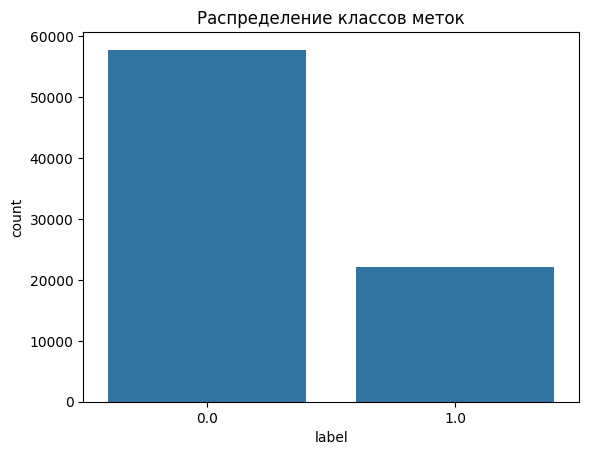

Соотношение классов: 
label
0.0    57820
1.0    22180
Name: count, dtype: int64


In [7]:
class_counts = df_train['label'].value_counts()

sns.countplot(x='label', data=df_train)
plt.title('Распределение классов меток')
plt.show()

print(f"Соотношение классов: \n{class_counts}")

Вывод: замечаем дисбаланс классов

### Анализ временных рядов

Анализ длин временных рядов

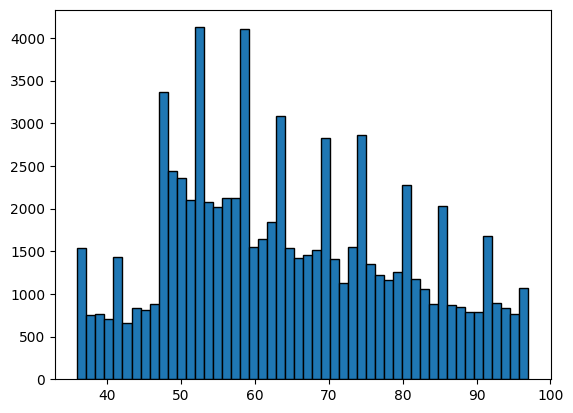

In [8]:
dates_lengths = df_train['dates'].apply(len)
plt.hist(dates_lengths, bins=50, edgecolor = 'black')
plt.show()

Вывод: будет необходимо приводить временные ряды к единой длинне

Проверим есть ли разница между длинно dates и values

In [9]:
values_lengths = df_train['values'].apply(len)
diff_lengths = dates_lengths - values_lengths
print(len([item for item in diff_lengths if item != 0]))

0


Вывод: Такие элементы отстутствуют

Распределение средних значений values

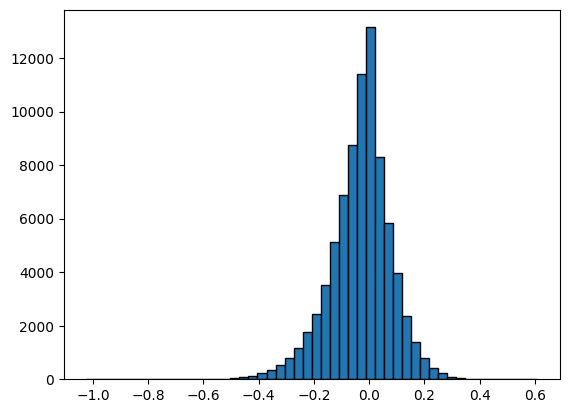

In [10]:
df_means = df_train['values'].apply(np.mean)

plt.hist(df_means, bins=50, edgecolor = 'black')
plt.show()

Рассчитаем кросс - корреляцию значений этого ряда с меткой

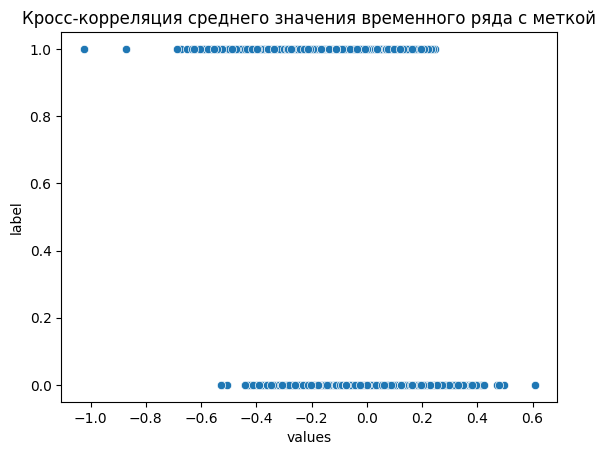

In [11]:
sns.scatterplot(x=df_means, y=df_train['label'])
plt.title('Кросс-корреляция среднего значения временного ряда с меткой')
plt.show()

Вывод: выделим закономерность, с ростом среднего values, растет вероятность пренадлежности к классу 0

## Гипотеза 1. Инжениринг фичей из колонок 'dates', 'values' позволит решить задачу при помощи базовых алгоритмов классфификации.

Выделим общие признаки из временных рядов

In [12]:
def generate_features(row):
    values = np.array(row['values'])
    dates = pd.to_datetime(row['dates']).map(datetime.toordinal)  # Преобразуем даты в числа

    features = {
        'mean_value': np.mean(values),
        'median_value': np.median(values),
        'std_value': np.std(values),
        'max_value': np.max(values),
        'min_value': np.min(values),
        'range_value': np.max(values) - np.min(values),
        'trend_slope': np.polyfit(range(len(values)), values, 1)[0],  # коэффициент линейного тренда
        'first_derivative_mean': np.mean(np.diff(values)),  # среднее первой производной
        'first_derivative_std': np.std(np.diff(values)),    # стандартное отклонение первой производной
        'autocorr_1': np.corrcoef(values[:-1], values[1:])[0, 1],  # автокорреляция с лагом 1
        'dates_mean': np.mean(dates),  # среднее значение дат в числовом формате
        'dates_min': np.min(dates),    # минимальная дата
        'dates_max': np.max(dates),    # максимальная дата
        'dates_range': np.max(dates) - np.min(dates),  # диапазон дат
    }
    return pd.Series(features)

In [13]:
df_train['dates'] = df_train['dates'].apply(pd.to_datetime)
df_features = df_train.apply(generate_features, axis=1)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encounter

Объединим с таргетом и удалим лишние колонки

In [14]:
df_train_h1 = pd.concat([df_train, df_features], axis=1)
df_train_h1 = df_train_h1.drop(columns=['dates', 'id', 'values'])
df_train_h1.tail(5)

,label,mean_value,median_value,std_value,max_value,min_value,range_value,trend_slope,first_derivative_mean,first_derivative_std,autocorr_1,dates_mean,dates_min,dates_max,dates_range
79995,0.0,0.163818,0.16000,1.303965,2.56,-3.64,6.20,-0.005509,0.043148,1.691542,0.154770,737789.927273,736968.0,738611.0,1643.0
79996,1.0,-0.112555,-0.18000,1.216413,2.16,-2.59,4.75,-0.012999,0.003455,1.313139,0.428092,736937.716981,736146.0,737730.0,1584.0
79997,0.0,-0.201373,-0.14000,1.182551,2.27,-2.89,5.16,0.039878,-0.042200,1.372824,0.302005,736785.470588,736024.0,737546.0,1522.0
79998,0.0,-0.075397,0.24000,1.491254,3.11,-2.85,5.96,0.006774,0.047742,1.605315,0.418320,736937.746032,735995.0,737881.0,1886.0
79999,1.0,-0.274635,0.00335,1.407661,2.87,-3.05,5.92,-0.038064,-0.036933,1.358001,0.538534,736724.627451,735964.0,737485.0,1521.0


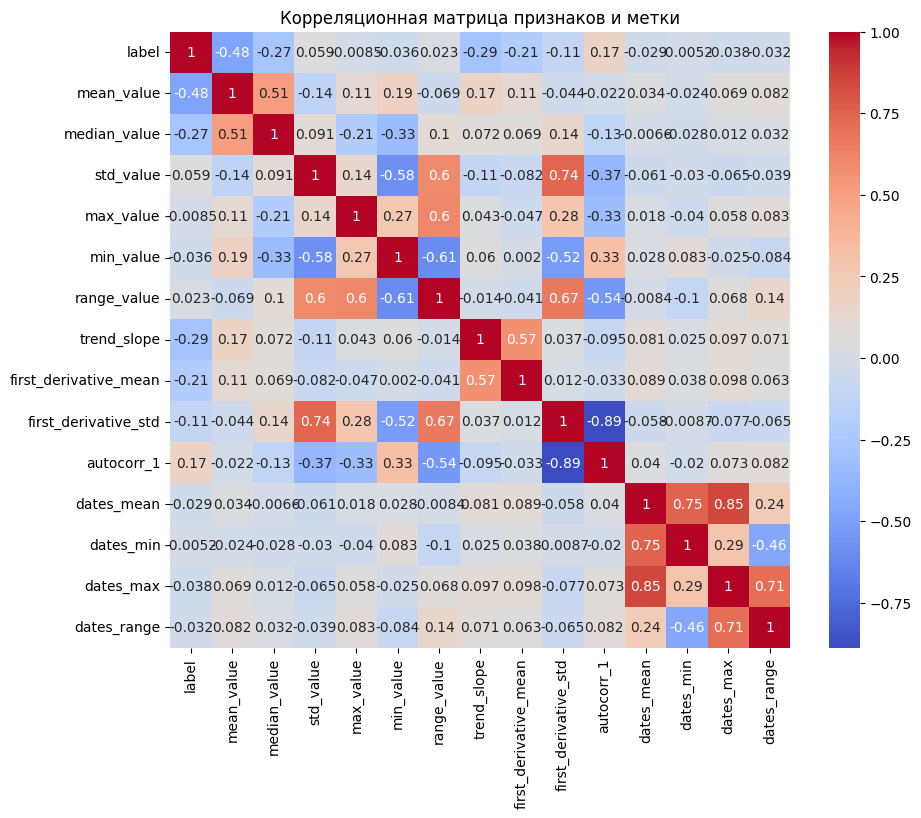

In [15]:
correlation = df_train_h1.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица признаков и метки')
plt.show()

Вывод: гипотеза неверна. Не было обнаруженно не одного параметра с 'сильной' корреляцией с label

## Гипотеза 2. Применим подход предсказания классов через LSTM, поскольку данная модель хорошо работает с временными рядами

Предобработка данных

In [21]:
df_train = pd.read_parquet(r'/content/train.parquet')

In [22]:
df_train_h2 = df_train

Преобразуем даты в числовые представления

In [25]:
def convert_to_timestamps(date_array):
    return [pd.to_datetime(date).timestamp() for date in date_array]

df_train_h2['dates'] = df_train_h2['dates'].apply(convert_to_timestamps)


In [26]:
X = df_train_h2[['dates', 'values']]
y = df_train_h2['label']

In [40]:
print(y)

0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
79995    0.0
79996    1.0
79997    0.0
79998    0.0
79999    1.0
Name: label, Length: 80000, dtype: float64


Выполним паддинг рядов

In [29]:
X_values = pad_sequences(X['values'], dtype='float32', padding='post')
X_dates = pad_sequences(X['dates'], dtype='float32', padding='post')

In [30]:
X_combined = np.stack([X_dates, X_values], axis=-1)

In [39]:
print(X_combined)

[[[ 0.57254136 -1.8434141 ]
  [ 0.57618815  0.81123406]
  [ 0.5795997   1.422304  ]
  ...
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]]

 [[ 0.5867757  -1.0219758 ]
  [ 0.5904225  -3.4662557 ]
  [ 0.5939517   0.06993606]
  ...
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]]

 [[ 0.62253803  0.30033946]
  [ 0.6261849   0.65095335]
  [ 0.629714    0.0799536 ]
  ...
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]]

 ...

 [[ 0.5795997  -0.76151973]
  [ 0.5832465  -2.2541332 ]
  [ 0.5867757  -1.8333966 ]
  ...
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]]

 [[ 0.57618815 -2.2741683 ]
  [ 0.5795997  -2.8351505 ]
  [ 0.5832465   0.94146204]
  ...
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]
  [-1.4039164   0.01984836]]

 [[ 0.57254136  0.14005883]
  [ 0.57618815 -0.7815549 ]
  [ 0.5795997   1.64269   ]
  ...
  [-1.4039164   0.019848

Нормализация

In [31]:
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined.reshape(-1, X_combined.shape[-1])).reshape(X_combined.shape)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

Создаем LSTM

In [46]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

In [47]:
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/4
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 111s 55ms/step - auc: 0.0104 - loss: nan - val_auc: 0.0000e+00 - val_loss: nan
Epoch 2/4
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 85s 43ms/step - auc: 0.0000e+00 - loss: nan - val_auc: 0.0000e+00 - val_loss: nan
Epoch 3/4
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 143s 43ms/step - auc: 0.0000e+00 - loss: nan - val_auc: 0.0000e+00 - val_loss: nan
Epoch 4/4
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 171s 57ms/step - auc: 0.0000e+00 - loss: nan - val_auc: 0.0000e+00 - val_loss: nan


Расчет ROC - AUC

In [35]:
results = model.evaluate(X_test, y_test)
print(f"Test ROC-AUC: {results[1]:.4f}")

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - auc: 0.0000e+00 - loss: nan
Test ROC-AUC: 0.0000


Визуализация обучения

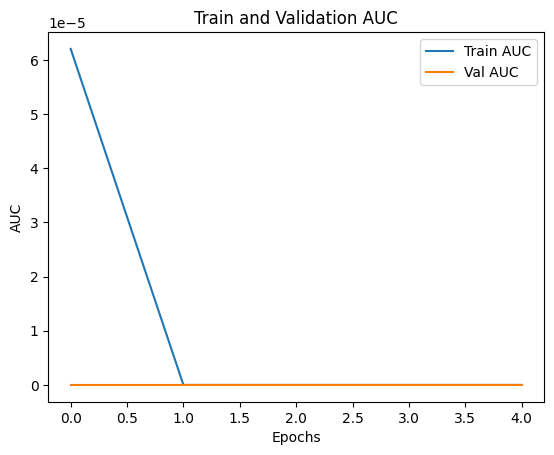

In [37]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Train and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

Вывод: данный пайплан не подошел для решения поставленной задачи

## Гипотеза 3. Применение полносвязной нейронной сети для обучения только на колонке 'values'

Предобработка данных

In [48]:
def prepare_data(df):
    X = np.array(df['values'])
    y = df['label'].values
    max_len = max(map(len, X))

    # Паддинг данных до максимальной длины
    X = np.array([np.pad(x, (0, max_len - len(x)), 'constant') for x in X])

    return X, y

In [49]:
X, y = prepare_data(df_train)

In [50]:
X[np.isnan(X)] = 0

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Масштабируем данные

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Построение модели и компиляция

In [56]:
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1],)))  # Плоская структура входных данных
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [57]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.7382 - loss: 0.5178 - val_auc: 0.8564 - val_loss: 0.4158
Epoch 2/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.8446 - loss: 0.4232 - val_auc: 0.8617 - val_loss: 0.4016
Epoch 3/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - auc: 0.8545 - loss: 0.4099 - val_auc: 0.8684 - val_loss: 0.3905
Epoch 4/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc: 0.8687 - loss: 0.3877 - val_auc: 0.8711 - val_loss: 0.3855
Epoch 5/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8724 - loss: 0.3875 - val_auc: 0.8726 - val_loss: 0.3862
Epoch 6/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.8741 - loss: 0.3835 - val_auc: 0.8753 - val_loss: 0.3789
Epoch 7/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.8823 - loss: 0.3704 - val_auc: 0.8772 - val_loss: 0.3795
Epoch 8/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.8837 - loss: 0.3709 - val_auc: 0.8795 - val_loss: 0.3748
Epoch 9/50
1600/1600 ━━━━━━━━━━━━━━━━━━━

Замер скора

In [58]:
y_pred_proba = model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC на тестовых данных: {roc_auc}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ROC-AUC на тестовых данных: 0.8710142299546823


Визуализация обучения

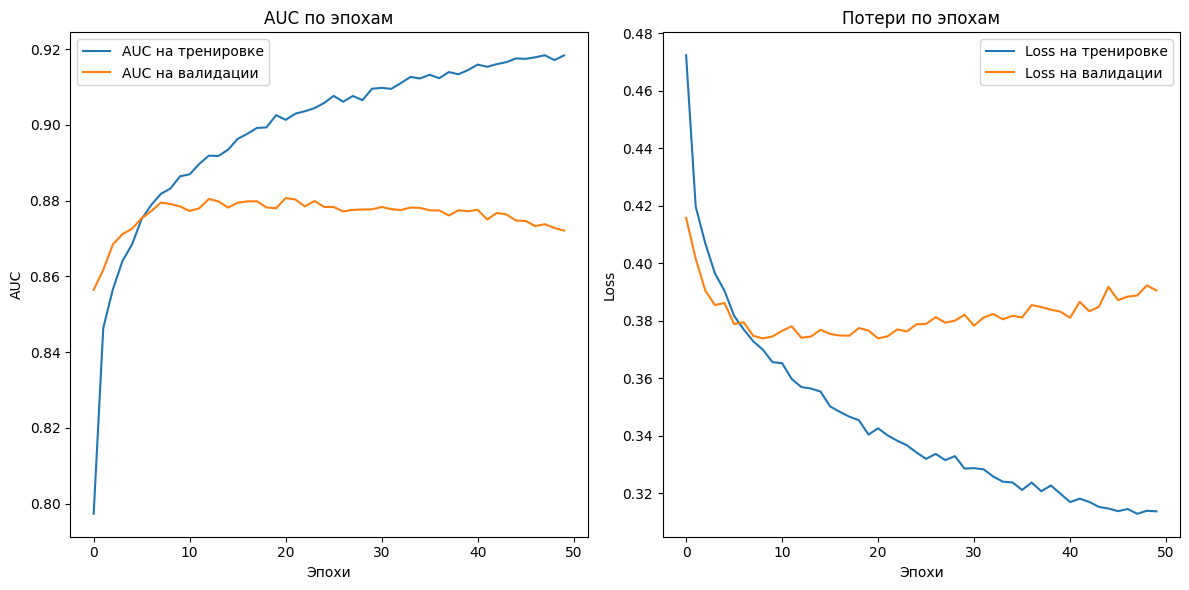

In [59]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='AUC на тренировке')
plt.plot(history.history['val_auc'], label='AUC на валидации')
plt.title('AUC по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('AUC')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss на тренировке')
plt.plot(history.history['val_loss'], label='Loss на валидации')
plt.title('Потери по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

ROC - AUC для текущего бейзлайна оказался 0.8710142299546823. Попробуем использовать Keras Tuner для улучшения результата

In [63]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(X_train.shape[1],)))

    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))  # Для бинарной классификации

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=[AUC(name='auc')]
    )

    return model

In [64]:
tuner = kt.Hyperband(
    build_model,
    objective='val_auc',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='tune_auc'
)

In [65]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [66]:
tuner.search(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[stop_early], batch_size=32)

Trial 30 Complete [00h 00m 46s]
val_auc: 0.8689305782318115

Best val_auc So Far: 0.8778194785118103
Total elapsed time: 00h 11m 58s


In [67]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Лучшие гиперпараметры:
- units_1: {best_hps.get('units_1')}
- dropout_1: {best_hps.get('dropout_1')}
- units_2: {best_hps.get('units_2')}
- dropout_2: {best_hps.get('dropout_2')}
- learning_rate: {best_hps.get('learning_rate')}
""")


Лучшие гиперпараметры:
- units_1: 224
- dropout_1: 0.30000000000000004
- units_2: 64
- dropout_2: 0.2
- learning_rate: 0.0004884141846074612



Обучение модели с лучшими гиперпараметрами

In [68]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[stop_early], batch_size=32)

Epoch 1/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.7225 - loss: 0.5256 - val_auc: 0.8518 - val_loss: 0.4149
Epoch 2/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.8446 - loss: 0.4243 - val_auc: 0.8620 - val_loss: 0.4005
Epoch 3/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - auc: 0.8561 - loss: 0.4083 - val_auc: 0.8673 - val_loss: 0.3933
Epoch 4/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.8711 - loss: 0.3874 - val_auc: 0.8696 - val_loss: 0.3907
Epoch 5/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.8733 - loss: 0.3842 - val_auc: 0.8737 - val_loss: 0.3829
Epoch 6/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8827 - loss: 0.3739 - val_auc: 0.8752 - val_loss: 0.3845
Epoch 7/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.8840 - loss: 0.3710 - val_auc: 0.8755 - val_loss: 0.3818
Epoch 8/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8922 - loss: 0.3570 - val_auc: 0.8758 - val_loss: 0.3808
Epoch 9/50
1280/1280 ━━━━━━━━━━━━━━━━━━━

In [69]:
y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC на тестовых данных: {roc_auc}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ROC-AUC на тестовых данных: 0.8689299793991125


Визуализация обучения

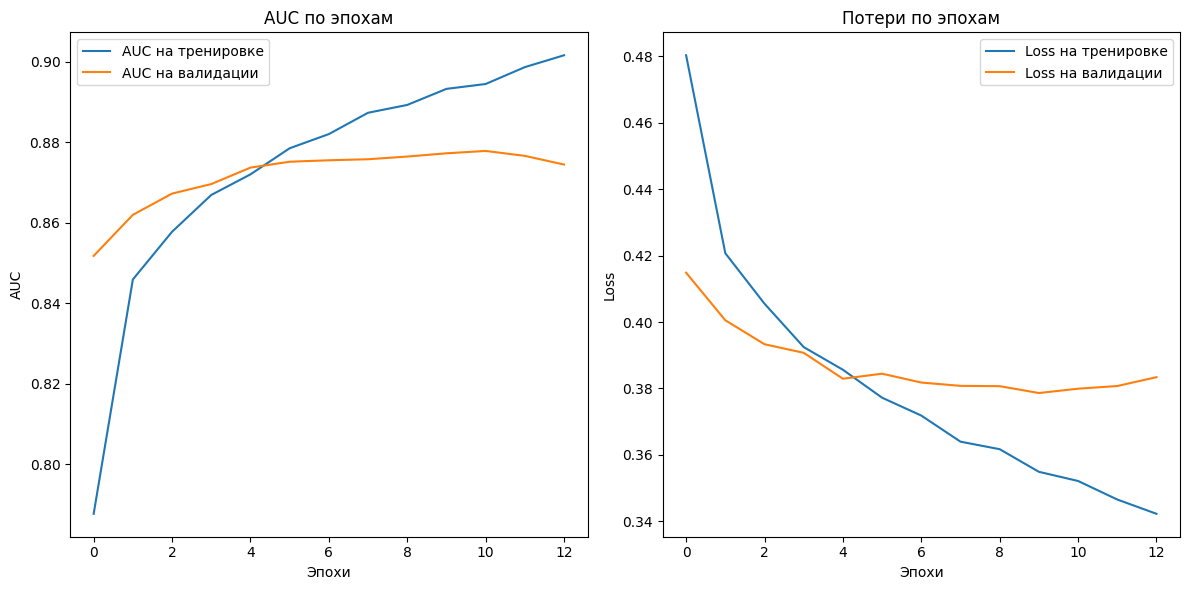

In [70]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='AUC на тренировке')
plt.plot(history.history['val_auc'], label='AUC на валидации')
plt.title('AUC по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('AUC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss на тренировке')
plt.plot(history.history['val_loss'], label='Loss на валидации')
plt.title('Потери по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()